# Object Detection - Bees

In [16]:
# install necessary packages
!pip3 install tensorflow_hub

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.6.0
The following GPU devices are available: 


In [33]:
# helper visualization functions 
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

Image downloaded to /var/folders/rv/l247c82x189_2095r1ddvjxw0000gn/T/tmpnpr4zhtr.jpg.


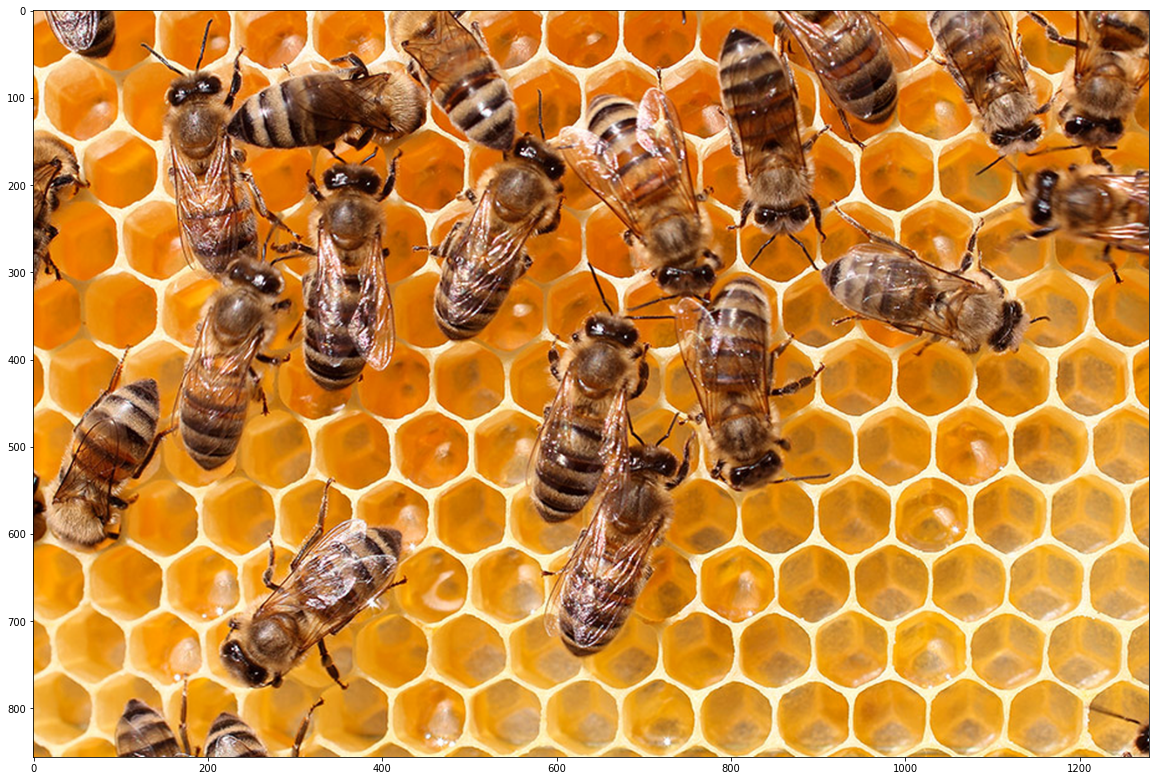

In [34]:
image_url = "https://www.libelium.com/wp-content/uploads/2015/02/monitoring-beehives-bees.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

## Predict with pretrained object detection model

In [12]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [43]:
# helper functions for model prediction
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)
    return result

Found 100 objects.
Inference time:  8.517139911651611
Font not found, using default font.


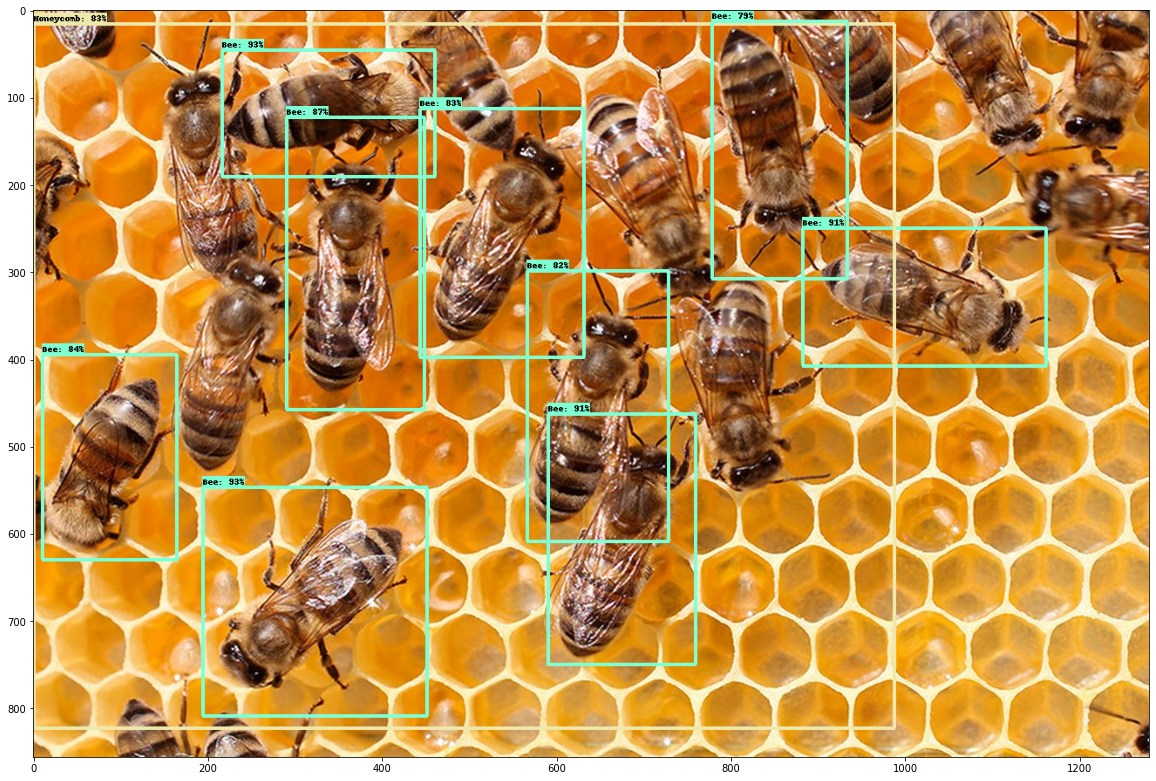

In [44]:
result = run_detector(detector, downloaded_image_path)

## Crop and Save detected bee images

In [50]:
print(result['detection_boxes'])

[[5.40458746e-02 1.68828458e-01 2.22838953e-01 3.60251427e-01]
 [6.39645100e-01 1.52261764e-01 9.44662094e-01 3.53631347e-01]
 [5.41012228e-01 4.60979462e-01 8.75412643e-01 5.94080925e-01]
 [2.92402446e-01 6.89542294e-01 4.75934625e-01 9.08574820e-01]
 [1.44461364e-01 2.27035120e-01 5.33901811e-01 3.50902200e-01]
 [4.62017536e-01 7.81633612e-03 7.35916674e-01 1.29664108e-01]
 [1.96646117e-02 0.00000000e+00 9.60516274e-01 7.72277355e-01]
 [1.32724285e-01 3.46873820e-01 4.63789582e-01 4.94223863e-01]
 [3.50018203e-01 4.42337126e-01 7.10944533e-01 5.69776833e-01]
 [1.54054770e-02 6.08588099e-01 3.59726131e-01 7.30309486e-01]
 [3.46304238e-01 5.70967019e-01 6.57967269e-01 7.01625407e-01]
 [8.72827545e-02 4.78198290e-01 3.94221097e-01 6.32031500e-01]
 [0.00000000e+00 3.05371642e-01 9.45820868e-01 1.00000000e+00]
 [2.17740517e-02 1.10419020e-01 3.84339660e-01 2.30340764e-01]
 [1.53335750e-01 0.00000000e+00 3.62923324e-01 5.66801690e-02]
 [0.00000000e+00 3.21716338e-01 1.95493802e-01 4.495960

In [ ]:
cropped_image = tf.image.crop_to_bounding_box(image, yminn, xminn, 
                                       ymaxx - yminn, xmaxx - xminn)

## Try out other beehive images!

In [51]:
image_urls = [
    "https://cdn.mos.cms.futurecdn.net/HixjyeXYJCrSDVGkZTmprP-1024-80.jpg",
    "https://5.imimg.com/data5/WD/CH/MY-76154918/stingless-bee-honey-500x500.jpg",
    ]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    result = run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)
    return result

Image downloaded to /var/folders/rv/l247c82x189_2095r1ddvjxw0000gn/T/tmpdgzvs_2o.jpg.
Found 100 objects.
Inference time:  7.985828161239624
Font not found, using default font.
Inference time: 8.129979848861694


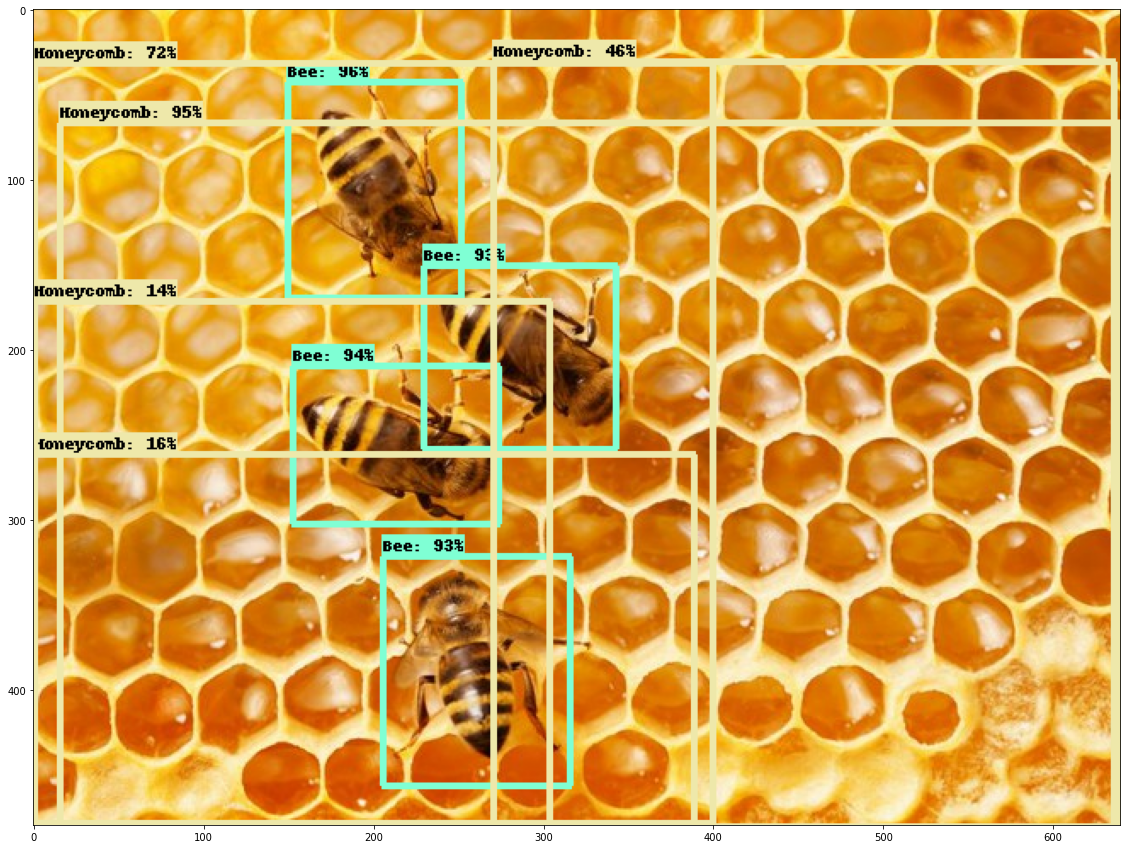

In [52]:
result = detect_img(image_urls[0])

Image downloaded to /var/folders/rv/l247c82x189_2095r1ddvjxw0000gn/T/tmp07clukpw.jpg.
Found 100 objects.
Inference time:  10.261487245559692
Font not found, using default font.
Inference time: 15.002493143081665


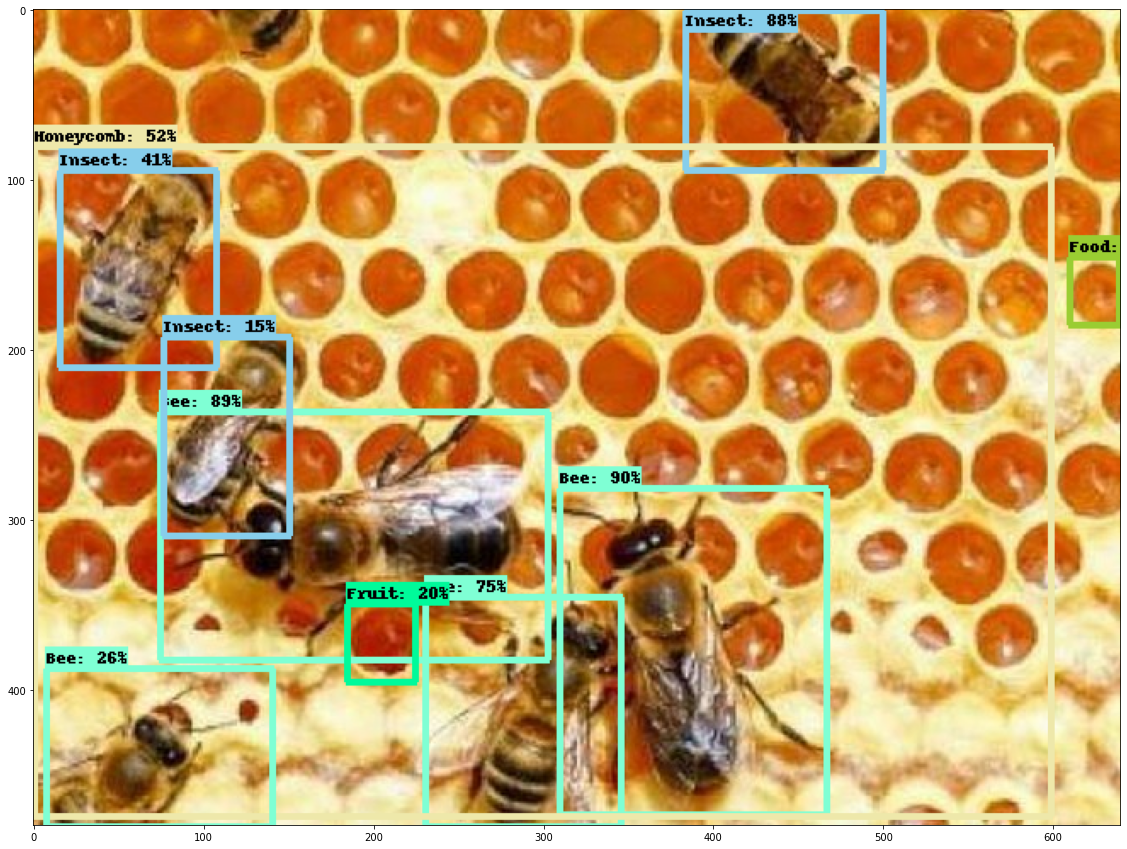

In [42]:
result = detect_img(image_urls[1])

## References
1. TensorFlow Object Detection Tutorial - https://www.tensorflow.org/hub/tutorials/object_detection